# Comparing LR, FCNN, CNN and MobileNetV2

### Import packages

In [1]:
import numpy as np
import torch 
import torchvision
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Visualize the Data

In [2]:
# create true labels for STL10
def create_true_labels_for_STL10() -> list: 
    true_labels =  ["Airplane",  # index 0
                    "Bird",      # index 1
                    "Car",       # index 2 
                    "Cat",       # index 3 
                    "Deer",      # index 4
                    "Dog",       # index 5
                    "Horse",     # index 6 
                    "Monkey",    # index 7 
                    "Ship",      # index 8 
                    "Truck"]     # index 9
    return true_labels
    
true_labels = create_true_labels_for_STL10()

Files already downloaded and verified


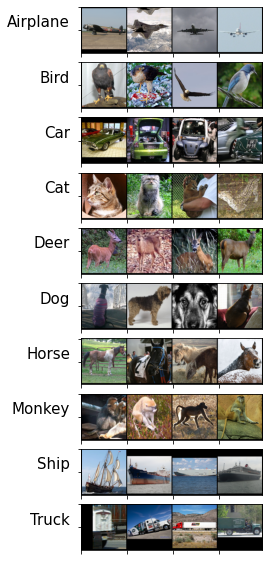

In [3]:
# plot some images
def plot_examples(images_per_label: int = 4, image_width: int = 3, image_size: int = 96) -> None:
    plot_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    set = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=plot_transform)
    loader = torch.utils.data.DataLoader(set)

    _, axes = plt.subplots(10, 1, figsize=(24, 10))
    axes = axes.flatten()

    iterator = iter(loader)

    for idx, label in enumerate(true_labels):
        counter = 0
        examples_per_class = torch.empty(images_per_label, image_width, image_size, image_size)

        while counter < images_per_label:
            example, l = next(iterator)
            if l == idx:
                examples_per_class[counter, :, :, :] = example
                counter += 1
        
        axes[idx].imshow(np.transpose(torchvision.utils.make_grid(examples_per_class), (1, 2, 0)))
        axes[idx].set_ylabel(str(label), rotation='horizontal', fontsize=15, horizontalalignment='right')
    for ax in axes:
            ax.set_yticklabels([])
            ax.set_xticklabels([])
    plt.show()


plot_examples()

### Pre-processing of the data

In [4]:
# load and preprocess the data via pytorch DataLoader 
def load_and_preprocess_data(train_batch: int = 64, test_batch: int = 64, train_size: float = 0.8, seed: int = 1, crop: int = 64, mean: tuple = (0.5, 0.5, 0.5), std: tuple = (0.5, 0.5, 0.5) ) -> tuple:
    trans_train = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                torchvision.transforms.RandomCrop(crop),
                                                torchvision.transforms.Normalize(mean, std),
                                                torchvision.transforms.RandomRotation(20),
                                                torchvision.transforms.RandomAffine(5)])
                                                
    trans_test = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                torchvision.transforms.CenterCrop(crop),
                                                torchvision.transforms.Normalize(mean, std)])

    train_data = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=trans_train)
    val_data = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=trans_test)
    test_data = torchvision.datasets.STL10(root='./data', split='test', download=True, transform=trans_test)

    labels = train_data.labels
    targets_idx = np.arange(len(labels))
    train_idx, val_idx = train_test_split(targets_idx, train_size=train_size, random_state=seed, shuffle=True, stratify=labels)

    train_sample = torch.utils.data.SubsetRandomSampler(train_idx)
    val_sample = torch.utils.data.SubsetRandomSampler(val_idx)

    load_train = torch.utils.data.DataLoader(train_data, batch_size=train_batch, sampler=train_sample)
    load_val = torch.utils.data.DataLoader(val_data, batch_size=test_batch, sampler=val_sample)
    load_test = torch.utils.data.DataLoader(test_data, batch_size=test_batch)

    return load_train, load_val, load_test, labels

load_train, load_val, load_test, labels = load_and_preprocess_data()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Files already downloaded and verified
Files already downloaded and verified


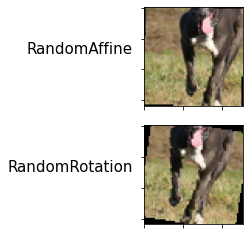

In [5]:
# example of the augmentations
def plot_augmentations(crop: int = 64) -> None:
    randomaffine = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.RandomCrop(crop),
                                                    torchvision.transforms.RandomAffine(5)])
    randomrotation = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.RandomCrop(crop),
                                                    torchvision.transforms.RandomRotation(20)])

    random_affine_data = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=randomaffine)
    random_rotation_data = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=randomrotation)

    affine_loader = torch.utils.data.DataLoader(random_affine_data)
    rotation_loader = torch.utils.data.DataLoader(random_rotation_data)

    iterator_affine = iter(affine_loader)
    iterator_rotation = iter(rotation_loader)

    _, axes = plt.subplots(2, 1, figsize=(8, 4))
    axes = axes.flatten()

    example_affine, _ = next(iterator_affine)
    example_rotation, _ = next(iterator_rotation)
    example_affine, _ = next(iterator_affine)
    example_rotation, _ = next(iterator_rotation)

    axes[0].imshow(np.transpose(torchvision.utils.make_grid(example_affine), (1, 2, 0)))
    axes[0].set_ylabel('RandomAffine', rotation='horizontal', fontsize=15, horizontalalignment='right')
    axes[1].imshow(np.transpose(torchvision.utils.make_grid(example_rotation), (1, 2, 0)))
    axes[1].set_ylabel('RandomRotation', rotation='horizontal', fontsize=15, horizontalalignment='right')

    for ax in axes:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
    plt.show()

plot_augmentations()


###  Classification with Various Networks

In [6]:
# multi-class logistic regression
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super(LogisticRegression, self).__init__()
        self.flatten = torch.nn.Flatten(start_dim=1)
        self.layer = torch.nn.Linear(input_dim, output_dim)

    def forward(self, features: np.ndarray):
        flattened_features = self.flatten(features)
        predictions = self.layer(flattened_features)
        return predictions

In [7]:
# Fully-connected NN with 3 hidden layers over flattened version of the images followed by a classification layer
# With dropout and batch normalization
class FullyConnectedNet(torch.nn.Module):
    def __init__(self, layer_size: list, drop_precentage: float):
        super(FullyConnectedNet, self).__init__()
        self.flatten = torch.nn.Flatten(start_dim=1)
        self.layer1 = torch.nn.Linear(layer_size[0], layer_size[1])
        self.normalize1 = torch.nn.BatchNorm1d(layer_size[1])
        self.dropout1 = torch.nn.Dropout(p=drop_precentage)
        self.layer2 = torch.nn.Linear(layer_size[1], layer_size[2])
        self.normalize2 = torch.nn.BatchNorm1d(layer_size[2])
        self.dropout2 = torch.nn.Dropout(p=drop_precentage)
        self.layer3 = torch.nn.Linear(layer_size[2], layer_size[3])
        self.normalize3 = torch.nn.BatchNorm1d(layer_size[3])
        self.dropout3 = torch.nn.Dropout(p=drop_precentage)
        self.output = torch.nn.Linear(layer_size[3], layer_size[4])

    def forward(self, features: np.ndarray, activation_function: torch.nn.functional = torch.nn.functional.relu):
        flattened_features = self.flatten(features)
        data_after_hidden_1 = self.dropout1(activation_function(self.normalize1(self.layer1(flattened_features))))
        data_after_hidden_2 = self.dropout2(activation_function(self.normalize2(self.layer2(data_after_hidden_1))))
        data_after_hidden_3 = self.dropout3(activation_function(self.normalize3(self.layer3(data_after_hidden_2))))
        predictions = self.output(data_after_hidden_3)
        return predictions

In [8]:
# CNN with two convolution layers and two pooling layers followed by two fully connected layers. 
# With dropout applied to the convolution layers and batch normalization applied to the fully connected layers.
class ConvNet(torch.nn.Module):
    def __init__(self, channel_size: list, kernel_size: list, fclayer_size: list, drop_precentage: float = 0.3, pool_size: int = 2):
        super(ConvNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(channel_size[0], channel_size[1], kernel_size[0])
        self.normalize1 = torch.nn.BatchNorm2d(channel_size[1])
        self.pooling1 = torch.nn.MaxPool2d(pool_size, pool_size)
        self.conv2 = torch.nn.Conv2d(channel_size[1], channel_size[2], kernel_size[1])
        self.normalize2 = torch.nn.BatchNorm2d(channel_size[2])
        self.pooling2 = torch.nn.MaxPool2d(pool_size, pool_size)
        self.fullyconnected1 = torch.nn.Linear(fclayer_size[0], fclayer_size[1])
        self.dropout1 = torch.nn.Dropout(p=drop_precentage)
        self.fullyconnected2 = torch.nn.Linear(fclayer_size[1], fclayer_size[2])
        self.dropout2 = torch.nn.Dropout(p=drop_precentage)
        self.output = torch.nn.Linear(fclayer_size[2], fclayer_size[3]) 

    def forward(self, features: np.ndarray, activation_function: torch.nn.functional = torch.nn.functional.relu):
        data_after_conv1 = self.pooling1(activation_function(self.normalize1(self.conv1(features))))
        data_after_conv2 = self.pooling2(activation_function(self.normalize2(self.conv2(data_after_conv1))))
        data_after_conv2 = data_after_conv2.view(-1, self.fullyconnected1.in_features) # to fix the size for the input of the linear layer
        data_after_FC1 = self.dropout1(activation_function(self.fullyconnected1(data_after_conv2)))
        data_after_FC2 = self.dropout2(activation_function(self.fullyconnected2(data_after_FC1)))
        predictions = self.output(data_after_FC2)
        return predictions

In [9]:
# a function to calculate the size of the first fully connected layer after the CNN
def get_length_of_fully_connected_layer(channel_size, kernel_size, pool_size):
    img_size = (((channel_size[-1] - kernel_size[0] + 1) // pool_size) - kernel_size[1] + 1) // pool_size
    return channel_size[-1] * img_size * img_size 

In [10]:
# A fixed pre-trained MobileNetV2 as feature extractor followed by two fully connected layers and an additional classification layer
class Fixed_MobileNetV2(torch.nn.Module):
    def __init__(self, layer_size: list, pretrained: bool = True):
        super(Fixed_MobileNetV2, self).__init__()
        
        self.mobilenetv2 = torchvision.models.mobilenet.mobilenet_v2(pretrained)
        for param in self.mobilenetv2.parameters():
            param.requires_grad = False

        self.layer1 = torch.nn.Linear(self.mobilenetv2.classifier[1].out_features, layer_size[0])
        self.layer2 = torch.nn.Linear(in_features=layer_size[0], out_features=layer_size[1])
        self.output = torch.nn.Linear(layer_size[1], layer_size[2])
        

    def forward(self, features, activation_function: torch.nn.functional = torch.nn.functional.relu):
        MobileNetV2_features = activation_function(self.mobilenetv2(features))
        data_after_layer_1 = activation_function(self.layer1(MobileNetV2_features))
        data_after_layer_2 = activation_function(self.layer2(data_after_layer_1))
        predictions = self.output(data_after_layer_2)
        return predictions

In [11]:
# A learned pre-trained MobileNetV2 as feature extractor followed by two fully connected layers and an additional classification layer
class Learned_MobileNetV2(torch.nn.Module):
    def __init__(self, layer_size: list, pretrained: bool = True):
        super(Learned_MobileNetV2, self).__init__()
        
        self.mobilenetv2 = torchvision.models.mobilenet.mobilenet_v2(pretrained)
        self.layer1 = torch.nn.Linear(self.mobilenetv2.classifier[1].out_features, layer_size[0])
        self.layer2 = torch.nn.Linear(in_features=layer_size[0], out_features=layer_size[1])
        self.output = torch.nn.Linear(layer_size[1], layer_size[2])


    def forward(self, features, activation_function: torch.nn.functional = torch.nn.functional.relu):
        MobileNetV2_features = activation_function(self.mobilenetv2(features))
        data_after_layer_1 = activation_function(self.layer1(MobileNetV2_features))
        data_after_layer_2 = activation_function(self.layer2(data_after_layer_1))
        predictions = self.output(data_after_layer_2)
        return predictions

In [12]:
# testing function for the test data on a trained model
def test(load_test: torch.utils.data.dataloader, model, device):
    crit = torch.nn.CrossEntropyLoss()
    model.eval()
    total_loss ,total_correct ,test_total  = 0, 0, 0
    with torch.no_grad():
        for n_batch, data in enumerate(load_test):
            features, labels = data
            features = features.to(device)
            labels = labels.to(device)

            predictions = model(features)
            _, predicted = torch.max(predictions.data, 1)
            test_total += labels.size(0)
            total_correct += sum((predicted == labels)).item()
            loss = crit(predictions, labels)
            total_loss += loss.item()

    accuracy = total_correct / test_total
    loss = total_loss / n_batch
    return accuracy, loss

In [13]:
# training a model and validating it using the test function
def train_net(load_train: torch.utils.data.dataloader, load_val: torch.utils.data.dataloader, model, device, optim: str, lr: float = 0.001, n_epochs: int = 200, moment: float = 0.2, wd: float = 0.05):
    if optim == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=moment, weight_decay=wd)
    elif optim == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    try: 
        optimizer.zero_grad()
    except UnboundLocalError as err: 
        print("Set optimizer to adam/sgd only")


    crit = torch.nn.CrossEntropyLoss()
    train_loss, val_loss, train_acc, val_acc = ([] for i in range(4))
    for epoch in range(n_epochs):
        model.train()
        total_loss ,total_correct ,train_total  = 0, 0, 0
        for n_batch, data in enumerate(load_train):
            features, labels = data
            features = features.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            
            predictions = model(features)
            loss = crit(predictions, labels)
            loss.backward()

            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(predictions.data, 1)
            total_correct += sum(predicted == labels).item()
            train_total += labels.size(0)

        v_acc, v_loss = test(load_val, model, device)
        train_loss.append(total_loss / n_batch)
        train_acc.append(total_correct / train_total)
        val_acc.append(v_acc)
        val_loss.append(v_loss)

        precentage = (epoch * 100) // n_epochs
        print("Model Training: " + str(precentage) + "%", end = "\r")

        # print('Epoch: {0}\nLoss: {1:.3f}\nTrain Accuracy: {2:.3f}\nValidation Accuracy: {3:.3f}'
        # .format(epoch, train_loss[-1], train_acc[-1], val_acc[-1]))

    return train_loss, val_loss, train_acc, val_acc, model

In [14]:
# function to plot loss vs epochs
def plot_loss(train_loss, val_loss, train_acc, val_acc, epochs, lr, optimizer, l2_reg):
    steps = np.arange(epochs)
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.plot(steps, train_loss, label="train loss", color='red')
    ax1.plot(steps, val_loss, label="val loss", color='blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy')
    ax2.plot(steps, train_acc, label="train acc", color='green')
    ax2.plot(steps, val_acc, label="val acc", color='yellow')

    fig.legend(loc='center right', bbox_to_anchor=(0.8, 0.6))
    fig.suptitle('Learning rate={}, L2 regularization factor={}, Optimizer={}'.format(lr, l2_reg, optimizer))
    fig.tight_layout()
    plt.show()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model: LogisticRegression(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer): Linear(in_features=12288, out_features=10, bias=True)
), Learning Rate: 5e-05, Optimizer: sgd, L2 Regularization: 0.01, Epochs: 150
Test Accuracy: 0.278
Test Loss:2.047


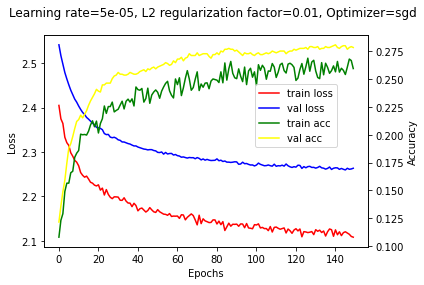

Model: FullyConnectedNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=12288, out_features=200, bias=True)
  (normalize1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (layer2): Linear(in_features=200, out_features=100, bias=True)
  (normalize2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (layer3): Linear(in_features=100, out_features=50, bias=True)
  (normalize3): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (output): Linear(in_features=50, out_features=10, bias=True)
), Learning Rate: 0.001, Optimizer: sgd, L2 Regularization: 0.01, Epochs: 200
Test Accuracy: 0.359
Test Loss:1.825


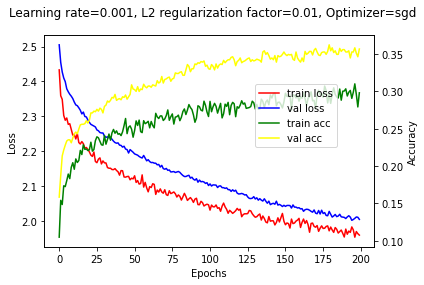

Model: ConvNet( 99%
  (conv1): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1))
  (normalize1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 64, kernel_size=(3, 3), stride=(1, 1))
  (normalize2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pooling2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fullyconnected1): Linear(in_features=12544, out_features=100, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fullyconnected2): Linear(in_features=100, out_features=50, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (output): Linear(in_features=50, out_features=10, bias=True)
), Learning Rate: 0.0001, Optimizer: adam, L2 Regularization: 0.0001, Epochs: 200
Test Accuracy: 0.596
Test Loss:1.145


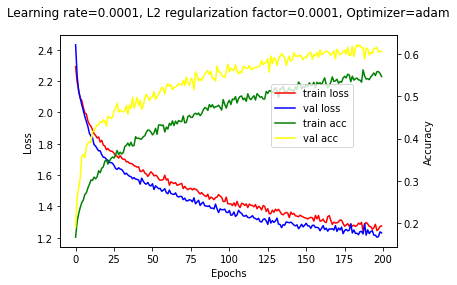

Model: Fixed_MobileNetV2(
  (mobilenetv2): MobileNetV2(
    (features): Sequential(
      (0): ConvBNActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 96, kernel_si

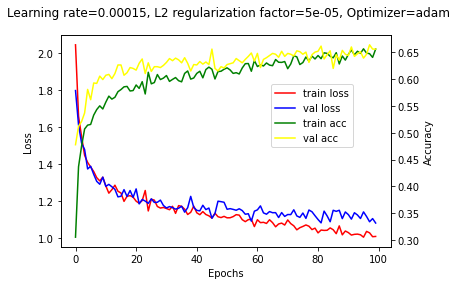

Model: Learned_MobileNetV2(
  (mobilenetv2): MobileNetV2(
    (features): Sequential(
      (0): ConvBNActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 96, kernel_

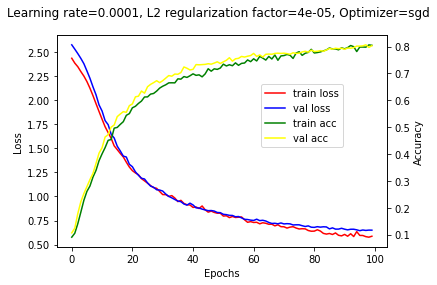

In [15]:
# set epoch, learning rate, optimizer, l2_reg, and seed
# momentum for sgd = 0.2
epochs = [150, 200, 200, 100, 100]
lr = [0.00005, 0.001, 0.0001, 0.00015, 0.0001] 
optim = ['sgd', 'sgd', 'adam', 'adam', 'sgd']
l2_reg = [0.01, 0.01, 0.0001, 0.00005, 4e-05] 
momentu = [0.2, 0.25, 0, 0, 0.9] 
seed = 1

# set batch size and split into train/validation
train_batch_size = 128
test_batch_size = 128
train_part = 0.75

# set cuda settings
cuda = True
use_cuda = cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
np.random.seed(seed)
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.enabled = use_cuda
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# load data via the load_and_preprocess_data function
load_train, load_val, load_test, labels = load_and_preprocess_data(train_batch_size, test_batch_size, train_part, seed)

# set models
input_size = 64 * 64 * 3
output_size = len(true_labels)
LR = LogisticRegression(input_dim=input_size, output_dim=output_size).to(device)
input_size = 64 * 64 * 3
hidden1_size = 200
hidden2_size = 100
hidden3_size = 50
output_size = len(true_labels)
layers = [input_size, hidden1_size, hidden2_size, hidden3_size, output_size]
dropout_precentage = 0.3
FCNN = FullyConnectedNet(layer_size=layers, drop_precentage=dropout_precentage).to(device)
channel_size = [3, 20, 64]
kernel_size = [3, 3]
pool = 2
fclayer_size = [get_length_of_fully_connected_layer(channel_size, kernel_size, pool), 100, 50, 10]
CNN = ConvNet(channel_size, kernel_size, fclayer_size, pool_size=pool).to(device)
layer_size = [500, 100, output_size]
FMNV2 = Fixed_MobileNetV2(layer_size).to(device)
layer_size = [500, 100, output_size]
LMNV2 = Learned_MobileNetV2(layer_size).to(device)

models = [LR, FCNN, CNN, FMNV2, LMNV2]

# run over all models
for idx, model in enumerate(models):
    train_loss, val_loss, train_acc, val_acc, model = train_net(load_train, load_val, model, device, optim[idx], lr[idx], epochs[idx], momentu[idx], l2_reg[idx])
    test_acc, test_loss = test(load_test, model, device)
    print('Model: {0}, Learning Rate: {1}, Optimizer: {2}, L2 Regularization: {3}, Epochs: {4}'.format(model, lr[idx], optim[idx], l2_reg[idx], epochs[idx]))
    print('Test Accuracy: {0:.3f}\nTest Loss:{1:.3f}'.format(test_acc, test_loss))
    plot_loss(train_loss, val_loss, train_acc, val_acc, epochs[idx], lr[idx], optim[idx], l2_reg[idx])